In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'

道路数据（全部来自ground_truth文件，未额外插值）

In [2]:
map_data = 'road.csv'
MD = pd.read_csv(map_data)
lat = np.array(MD.iloc[:, 0])
log = np.array(MD.iloc[:, 1])

In [3]:
path = 'gnss/1.csv'
position = pd.read_csv(path).iloc[:, [-3, -2, -1]]
position = position.drop_duplicates()
print(position)

X = np.array(position.iloc[:, 0])
Y = np.array(position.iloc[:, 1])
Z = np.array(position.iloc[:, 2])

       WlsPositionXEcefMeters  WlsPositionYEcefMeters  WlsPositionZEcefMeters
0               -2.693907e+06           -4.297452e+06            3.854203e+06
23              -2.693913e+06           -4.297455e+06            3.854195e+06
49              -2.693915e+06           -4.297454e+06            3.854187e+06
74              -2.693914e+06           -4.297453e+06            3.854189e+06
101             -2.693916e+06           -4.297456e+06            3.854191e+06
...                       ...                     ...                     ...
90028           -2.711799e+06           -4.268996e+06            3.873146e+06
90053           -2.711797e+06           -4.268995e+06            3.873145e+06
90078           -2.711796e+06           -4.268995e+06            3.873143e+06
90103           -2.711796e+06           -4.268994e+06            3.873141e+06
90128           -2.711797e+06           -4.268995e+06            3.873143e+06

[3362 rows x 3 columns]


坐标转换

In [4]:
a = 6378137.0
b = 6356752.31424518
def ECEF_to_WGS84(x, y, z):
    c = np.sqrt(((a * a) - (b * b)) / (a * a))
    d = np.sqrt(((a * a) - (b * b)) / (b * b))
    p = np.sqrt((x * x) + (y * y))
    q = np.arctan2((z * a), (p * b))
    Longitude = np.arctan2(y, x)
    Latitude = np.arctan2((z + (d * d) * b * np.power(np.sin(q), 3)), (p - (c * c) * a * np.power(np.cos(q), 3)))
    N = a / np.sqrt(1 - ((c * c) * np.power(np.sin(Latitude), 2)))
    Altitude = (p / np.cos(Latitude)) - N
    Longitude = Longitude * 180.0 / np.pi
    Latitude = Latitude * 180.0 / np.pi
    return Latitude, Longitude, Altitude

RawLat, RawLog, RawAlt = ECEF_to_WGS84(X, Y, Z)
del RawAlt

原始误差计算

In [5]:
def dis(lon1, lat1, lon2, lat2):
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    ang = np.sin(np.deg2rad(dlat)/2)**2 + np.cos(np.deg2rad(lat1)) * np.cos(np.deg2rad(lat2)) * np.sin(np.deg2rad(dlon/2))**2
    c = 2. * np.arcsin(np.sqrt(ang))
    r = 6367000
    return c * r

gt = 'gt/1.csv'
GT = pd.read_csv(gt).iloc[:, [2, 3]]
print(GT)
Lat = np.array(GT.iloc[:, 0])
Log = np.array(GT.iloc[:, 1])

initial_error = np.zeros_like(RawLat)
for i in range(RawLat.shape[0]):
    SinLat = RawLat[i]
    SinLog = RawLog[i]
    TrueLat = Lat[i]
    TrueLog = Log[i]
    initial_error[i] = dis(SinLog, SinLat, TrueLog, TrueLat)

matched_error = np.copy(initial_error)

      LatitudeDegrees  LongitudeDegrees
0           37.416619       -122.082065
1           37.416619       -122.082065
2           37.416619       -122.082065
3           37.416619       -122.082065
4           37.416619       -122.082065
...               ...               ...
3357        37.631664       -122.424975
3358        37.631667       -122.424971
3359        37.631667       -122.424972
3360        37.631667       -122.424972
3361        37.631667       -122.424972

[3362 rows x 2 columns]


筛选大误差点做匹配

In [6]:
def IsTooLarge(SinLat, SinLog, A):
    index = []
    for j in range(lat.shape[0]):
        if lat[j] < SinLat - A:
            pass
        elif lat[j] < SinLat + A:
            index.append(j)
        else:
            break
    j = 0
    while j < len(index):
        if SinLog - A < log[index[j]] < SinLog + A:
            j += 1
        else:
            index.pop(j)

    if len(index) == 0:
        return True, index
    else:
        return False, index

In [7]:
A = 6e-5
too_large_error = []

for i in range(RawLat.shape[0]):
    SinLat = RawLat[i]
    SinLog = RawLog[i]
    TrueLat = Lat[i]
    TrueLog = Log[i]
    ie = initial_error[i]

    if IsTooLarge(SinLat, SinLog, A)[0]:
        print('选定范围内无道路数据点！')
        print('=' * 50)
        too_large_error.append(i)
    else:
        print('有可匹配数据点')
        print('=' * 50)

print(too_large_error)
print(len(too_large_error))

有可匹配数据点
有可匹配数据点
选定范围内无道路数据点！
选定范围内无道路数据点！
选定范围内无道路数据点！
选定范围内无道路数据点！
选定范围内无道路数据点！
选定范围内无道路数据点！
选定范围内无道路数据点！
选定范围内无道路数据点！
选定范围内无道路数据点！
选定范围内无道路数据点！
选定范围内无道路数据点！
选定范围内无道路数据点！
选定范围内无道路数据点！
选定范围内无道路数据点！
选定范围内无道路数据点！
有可匹配数据点
选定范围内无道路数据点！
有可匹配数据点
有可匹配数据点
有可匹配数据点
有可匹配数据点
有可匹配数据点
选定范围内无道路数据点！
有可匹配数据点
选定范围内无道路数据点！
选定范围内无道路数据点！
有可匹配数据点
有可匹配数据点
选定范围内无道路数据点！
选定范围内无道路数据点！
有可匹配数据点
选定范围内无道路数据点！
选定范围内无道路数据点！
选定范围内无道路数据点！
选定范围内无道路数据点！
选定范围内无道路数据点！
选定范围内无道路数据点！
有可匹配数据点
选定范围内无道路数据点！
选定范围内无道路数据点！
选定范围内无道路数据点！
有可匹配数据点
有可匹配数据点
有可匹配数据点
有可匹配数据点
选定范围内无道路数据点！
有可匹配数据点
有可匹配数据点
有可匹配数据点
有可匹配数据点
有可匹配数据点
有可匹配数据点
有可匹配数据点
有可匹配数据点
有可匹配数据点
有可匹配数据点
有可匹配数据点
有可匹配数据点
有可匹配数据点
选定范围内无道路数据点！
有可匹配数据点
选定范围内无道路数据点！
选定范围内无道路数据点！
选定范围内无道路数据点！
选定范围内无道路数据点！
选定范围内无道路数据点！
选定范围内无道路数据点！
有可匹配数据点
有可匹配数据点
有可匹配数据点
选定范围内无道路数据点！
选定范围内无道路数据点！
选定范围内无道路数据点！
选定范围内无道路数据点！
选定范围内无道路数据点！
选定范围内无道路数据点！
有可匹配数据点
选定范围内无道路数据点！
选定范围内无道路数据点！
有可匹配数据点
选定范围内无道路数据点！
选定范围内无道路数据点！
选定范围内无道路数据点！
选定范围内无道路数据点！
有可匹配数据点
选定范围内无道路数据点！
选定范围内无道路数据点！
选定范围内无道路数据点！
选定范围内无道路数据点！
有可

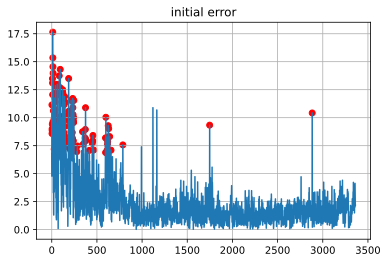

In [8]:
plt.plot(initial_error)
plt.title('initial error')
for index in too_large_error:
    plt.scatter(index, initial_error[index], c='r')
plt.grid(True)
plt.show()

优先处理孤立点

In [9]:
isolated = []
continuous = []
for i in too_large_error:
    if (i - 1) in too_large_error or (i + 1) in too_large_error:
        continuous.append(i)
    else:
        isolated.append(i)
print(isolated)
print('孤立误差点共', len(isolated))
print(continuous)
print('连续误差点共', len(continuous))

[18, 24, 47, 61, 92, 109, 112, 132, 134, 149, 158, 197, 199, 208, 229, 239, 278, 283, 341, 348, 378, 415, 448, 456, 465, 599, 614, 625, 628, 630, 641, 656, 787, 1748, 2883]
孤立误差点共 35
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 26, 27, 30, 31, 33, 34, 35, 36, 37, 38, 40, 41, 42, 63, 64, 65, 66, 67, 68, 72, 73, 74, 75, 76, 77, 79, 80, 82, 83, 84, 85, 87, 88, 89, 90, 94, 95, 96, 98, 99, 100, 101, 105, 106, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 137, 138, 140, 141, 142, 143, 144, 145, 146, 147, 185, 186, 187, 188, 189, 190, 191, 194, 195, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 223, 224, 225, 226, 227, 231, 232, 233, 234, 235, 236, 241, 242, 243, 245, 246, 370, 371, 372, 374, 375, 452, 453, 595, 596, 616, 617, 618, 619, 620]
连续误差点共 133


原始水平：
95分位数 6.989720842648051
匹配后水平：
95分位数 6.315808551906252


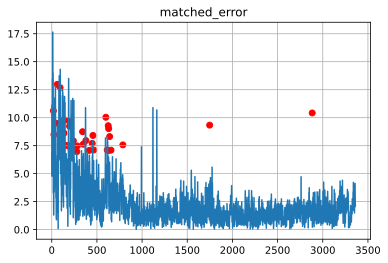

In [10]:
for i in isolated:
    RawLat[i] = (RawLat[i - 1] + RawLat[i + 1])/2.
    RawLog[i] = (RawLog[i - 1] + RawLog[i + 1])/2.
    matched_error[i] = dis(RawLog[i], RawLat[i], Log[i], Lat[i])

print('原始水平：')
print('95分位数', np.quantile(initial_error, .95))

print('匹配后水平：')
print('95分位数', np.quantile(matched_error, .95))

plt.plot(matched_error)
plt.title('matched_error')
for index in isolated:
    plt.scatter(index, initial_error[index], c='r')
plt.grid(True)
plt.show()

处理连续点

In [11]:
def FindRoad(SinLat, SinLog):
    for i in range(7, 21):
        flag, index = IsTooLarge(SinLat, SinLog, i * 1e-5)
        if not flag:
            return index
    return None

105
匹配后水平：
95分位数 6.132119906125604


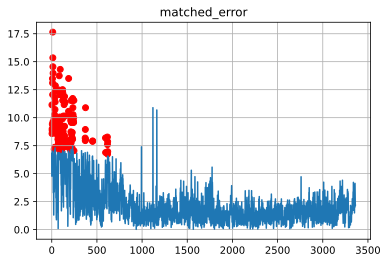

In [15]:
matched = []
for i in continuous:
    if (i + 1) in continuous:
        RoadData = FindRoad(RawLat[i], RawLog[i])
        mid = int(len(RoadData) / 2)
        ang = np.arctan((RawLat[i] - lat[RoadData[mid]]) / (RawLog[i] - log[RoadData[mid]]))

        for j in range(-20, 21, 1):
            l = j / 10. * A
            x = l * np.cos(ang)
            y = l * np.sin(ang)
            NewLat = RawLat[i] + y
            NewLog = RawLog[i] + x
            if not IsTooLarge(NewLat, NewLog, A)[0]:
                RawLat[i] = NewLat
                RawLog[i] = NewLog
                matched.append(i)
                matched_error[i] = dis(RawLog[i], RawLat[i], Log[i], Lat[i])
                break

    else:
        RawLat[i] = (RawLat[i - 1] + RawLat[i + 1])/2.
        RawLog[i] = (RawLog[i - 1] + RawLog[i + 1])/2.
        matched_error[i] = dis(RawLog[i], RawLat[i], Log[i], Lat[i])

#     if (FindRoad(RawLat[i], RawLog[i])) == None:
#         still_large.append(i)
print(len(matched))

print('匹配后水平：')
print('95分位数', np.quantile(matched_error, .95))

plt.plot(matched_error)
plt.title('matched_error')
for index in continuous:
    plt.scatter(index, initial_error[index], c='r')
plt.grid(True)
plt.show()